<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/TextCNN_with_TF_IDF_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/d5dd93d5-d7a7-4488-9bfb-8824d7cffe39

The create_text_cnn_model function you provided constructs a TextCNN model for binary text classification. This model uses multiple convolutional layers with different kernel sizes to capture various features from the text data, followed by pooling and concatenation. Here's a detailed explanation of the components:

Inputs Layer: Specifies the input shape, which is the maximum length of the sequences.
Embedding Layer: Transforms input tokens into dense vectors of fixed size (embedding_dim).
Convolutional and Pooling Layers: Three sets of convolutional layers with different kernel sizes (3, 4, and 5) followed by max pooling. These layers help in capturing different n-gram features from the text.
Concatenate Layer: Concatenates the outputs of the pooling layers along the specified axis.
Flatten Layer: Flattens the concatenated outputs into a single dimension.
Dense Layer: A fully connected layer with ReLU activation.
Dropout Layer: Helps prevent overfitting by randomly dropping units during training.
Output Layer: A single neuron with sigmoid activation for binary classification.
Compile Model: Configures the model for training with binary cross-entropy loss, the Adam optimizer, and accuracy as a metric.

https://chatgpt.com/share/6b20ab3c-04a2-4b5b-b39b-6531835e3571


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string


# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


# Preprocess the data

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):  # Fixed this line
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


## Save the cleaned dataset

In [ ]:
# Save the cleaned dataset as an Excel file
#dataset.to_excel('cleaned_14932_ARPs_and_Programming_Posts.xlsx', index=False, engine='openpyxl')

In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(lemmatized)


# Ensure all values in 'Question_body' are strings and handle NaNs and # Convert 'Question_body' to string (to avoid NaN issues)
dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)


In [ ]:
# Save processed dataset
#dataset.to_excel('Preprocessed_14932_ARPs_and_Programming_Posts.xlsx', index=False)

#dataset.head()

In [ ]:
# Preprocess the data for TextCNN
X = dataset['Question_body_preprocessed']
y = dataset['Label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 200 #I changed this line from 100 to 200, to match with the description in the paper writing
max_length = 500
trunc_type = 'post'
padding_type = 'post'

# Import the correct Tokenizer from tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


# Pad the sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# TextCNN model


In [ ]:

def model(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,)) #Imput Layer
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs) #Embedding Layer

    conv1 = Conv1D(128, 3, activation='relu')(embedding)       #First Convolutional Block
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(embedding)       #Second Convolutional Block
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(embedding)       #Third Convolutional Block
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)  #Concatenation Layer
    flatten = Flatten()(concatenated)                          #Flatten Layer
    dense1 = Dense(128, activation='relu')(flatten)            #Fully Connected Layer
    dropout = Dropout(0.5)(dense1)                             #Dropout Layer which prevent overfitting
    outputs = Dense(1, activation='sigmoid')(dropout)          #Output Layer:

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create the model

In [ ]:
# Create the model
text_cnn_model = create_text_cnn_model(vocab_size, embedding_dim, max_length)

# Display the model summary

In [ ]:
# Display the model summary
text_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 100)       │        500,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 498, 128)       │         38,528 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 497, 128)       │         51,328 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 496, 128)       │         64,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 249, 128)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 248, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 248, 128)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 745, 128)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 95360)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     12,206,208 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,860,321 (49.06 MB)

 Trainable params: 12,860,321 (49.06 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
#history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])
history = text_cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = text_cnn_model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 242s 638ms/step - accuracy: 0.8118 - loss: 0.3809 - val_accuracy: 0.9387 - val_loss: 0.1645
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 254s 678ms/step - accuracy: 0.9675 - loss: 0.0967 - val_accuracy: 0.9478 - val_loss: 0.1723
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 255s 660ms/step - accuracy: 0.9837 - loss: 0.0588 - val_accuracy: 0.9394 - val_loss: 0.2081
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 265s 668ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.9327 - val_loss: 0.3143
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 235s 629ms/step - accuracy: 0.9956 - loss: 0.0161 - val_accuracy: 0.9320 - val_loss: 0.3313
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 271s 653ms/step - accuracy: 0.9943 - loss: 0.0175 - val_accuracy: 0.9327 - val_loss: 0.3675
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 253s 628ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9391 - val_loss: 0.4508
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 273s 658ms/step - accuracy: 0.9963 -

# Predict on new data

# Evaluate predictions

In [ ]:
# Predict on new data
y_pred = text_cnn_model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# If y_test is already binary, use it directly
y_true_classes = y_test  # No need to apply argmax


# Evaluate predictions
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes)
print(report)


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1497
           1       0.94      0.92      0.93      1490

    accuracy                           0.93      2987
   macro avg       0.93      0.93      0.93      2987
weighted avg       0.93      0.93      0.93      2987



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
# Calculate precision, recall, f1-score, and support
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate class-wise accuracy
accuracy_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
accuracy_class_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) > 0 else 0

# Compute overall accuracy
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Print metrics
print(f'Class 0 - Precision: {precision_class[0]:.4f}, Recall: {recall_class[0]:.4f}, F1-score: {f1_class[0]:.4f}, Support: {support_class[0]}, Accuracy: {accuracy_class_0:.4f}')
print(f'Class 1 - Precision: {precision_class[1]:.4f}, Recall: {recall_class[1]:.4f}, F1-score: {f1_class[1]:.4f}, Support: {support_class[1]}, Accuracy: {accuracy_class_1:.4f}')
print(f'Overall Accuracy: {accuracy:.3f}')


Class 0 - Precision: 0.9231, Recall: 0.9385, F1-score: 0.9308, Support: 1497, Accuracy: 0.9385
Class 1 - Precision: 0.9372, Recall: 0.9215, F1-score: 0.9293, Support: 1490, Accuracy: 0.9215
Overall Accuracy: 0.930


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Predict on new data
y_pred = text_cnn_model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# If y_test is already binary, use it directly
y_true_classes = y_test  # No need to apply argmax

# Compute precision, recall, f1-score, and support (overall)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes, average='binary')

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred_classes)


# Print the overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step
Overall Precision: 0.9372013651877134
Overall Recall: 0.9214765100671141
Overall F1-score: 0.9292724196277495
Overall Accuracy: 0.9300301305657851


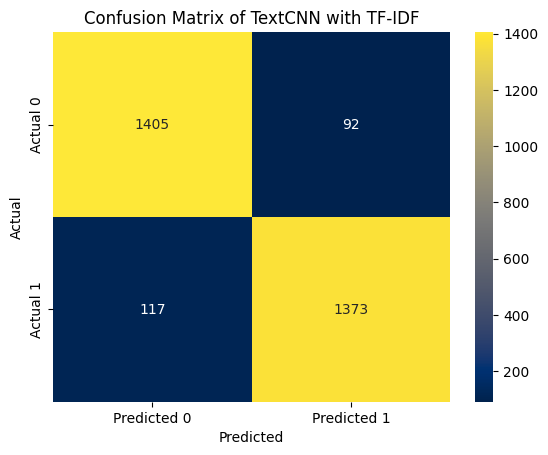

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_test is in binary format
y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with TF-IDF')
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step


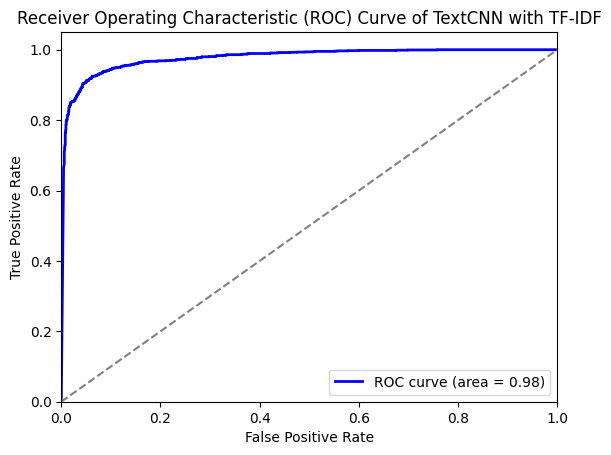

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities (instead of classes) for the positive class
y_pred_prob = text_cnn_model.predict(X_test_padded).ravel()

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of TextCNN with TF-IDF')
plt.legend(loc="lower right")
plt.show()
